<a href="https://colab.research.google.com/github/wbendinelli/Tera/blob/main/xray_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project goal**

Artificial intelligence (AI) has the potencial to revolutionize desease diagnosis and management by performing classification difficult for human exprtes and by rapidly reviewing immense amount of images. In this project, based on the article Kermany (2018), our objective is to classify individuals with pneumonia. After this first phase, our idea is to identify the cause of the pneumonia, whether it is viral or bacterial.

## **Dataset description**

The dataset is organized into 2 folders (train, test) and contains subfolders for each image category (pneumonia/normal). There are 5,863 X-Ray images (JPEG) and 2 categories (pneumonia/normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checkd by a third expert.

**Reference**: Kermany, Daniel S., et al. "[Identifying medical diagnoses and treatable diseases by image-based deep learning](https://www.sciencedirect.com/science/article/pii/S0092867418301545)." Cell 172.5 (2018): 1122-1131.



# Importing files


In [1]:
# Creating connection with Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/pneumonia_detection/chest_xray/

Mounted at /content/drive
test  train


In [2]:
# Libraries used
from pathlib import Path
import pandas as pd
import os
import numpy as np

# Defining path to the data directory
data_dir = Path('drive/MyDrive/pneumonia_detection/chest_xray/')

# Pathing to train directory
train_dir = data_dir / 'train'

# Pathing to test directory
test_dir = data_dir / 'test'

#Merging all files




In [3]:
# Getting the path to the normal and pneumonia sub-directories in train_dir
normal_cases_train_dir = train_dir / 'NORMAL'
pneumonia_cases_train_dir = train_dir / 'PNEUMONIA'

# Getting the path to the normal and pneumonia sub-directories in test_dir
normal_cases_test_dir = test_dir / 'NORMAL'
pneumonia_cases_test_dir = test_dir / 'PNEUMONIA'

In [4]:
# Validating the number of images originally split between training and test
list_path = [normal_cases_train_dir, 
             pneumonia_cases_train_dir,
             normal_cases_test_dir, 
             pneumonia_cases_test_dir]

for x in list_path:
  print(f'The number of images in the selected folder is {len(os.listdir(x))}')

#Comment: As we can see, the number of images distributed between the training 
#and test folders are biased and, therefore, our strategy will be to create a single
#folder with all the images to then correctly split these images.

The number of images in the selected folder is 1349
The number of images in the selected folder is 3884
The number of images in the selected folder is 234
The number of images in the selected folder is 390


In [5]:
# Getting the list with all the images
all_img = []

for x in list_path:
  all_img.extend(x.glob('*'))
  print(f'all images from directory {x} have been listed!')

all images from directory drive/MyDrive/pneumonia_detection/chest_xray/train/NORMAL have been listed!
all images from directory drive/MyDrive/pneumonia_detection/chest_xray/train/PNEUMONIA have been listed!
all images from directory drive/MyDrive/pneumonia_detection/chest_xray/test/NORMAL have been listed!
all images from directory drive/MyDrive/pneumonia_detection/chest_xray/test/PNEUMONIA have been listed!


#Labeling types of pneumonia

In [6]:
# Transforming list with all images into a dataframe
df_all_img = pd.DataFrame(all_img, columns=['complete_path'],index=None)

In [7]:
# Getting the path last name
df_all_img['basename_path'] = None

for index in df_all_img['complete_path'].index:
  df_all_img['basename_path'][index] = os.path.basename(df_all_img['complete_path'][index]) 

In [8]:
# Dummifying variables from path name 
df_all_img['bacteria_pneumonia'] = df_all_img['basename_path'].str.contains("bacteria", case=False)
df_all_img['bacteria_pneumonia'].replace({False: 0, True: 1}, inplace=True)

df_all_img['viral_pneumonia'] = df_all_img['basename_path'].str.contains("virus", case=False)
df_all_img['viral_pneumonia'].replace({False: 0, True: 1}, inplace=True)

conditions = [(df_all_img['bacteria_pneumonia'] == 1) | 
              (df_all_img['viral_pneumonia'] == 1),
              (df_all_img['bacteria_pneumonia'] == 0) | 
              (df_all_img['viral_pneumonia'] == 0)
             ]

results = [0, 1]
           
df_all_img['without_pneumonia'] = np.select(conditions, results)

# Viewing database samples

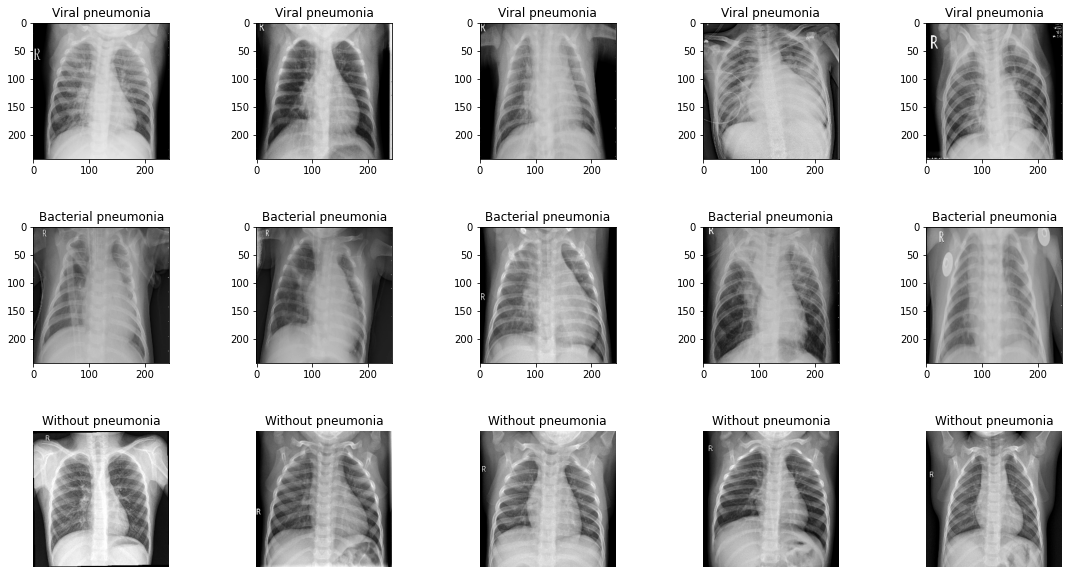

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.io import imread
from pylab import *
import cv2

# Get few samples for both the classes
viral_pneumonia_samples = (df_all_img[df_all_img['viral_pneumonia']==1].sample(n=5, replace=True, random_state=1))
bacteria_pneumonia_samples = (df_all_img[(df_all_img['bacteria_pneumonia']==1)].sample(n=5, replace=True, random_state=1))
without_pneumonia_samples = (df_all_img[df_all_img['without_pneumonia']==1].sample(n=5, replace=True, random_state=1))

# Concat the data in a single list 
samples = viral_pneumonia_samples.append(bacteria_pneumonia_samples).append(without_pneumonia_samples).reset_index()['complete_path']

# Plot the data 
fig, ax = plt.subplots(3,5, figsize=(20,10))
fig.subplots_adjust(hspace = .5, wspace=.001)

ax = ax.ravel()

for i in range(15):
    img = imread(samples[i])
    img = cv2.resize(img, (244,244))
    ax[i].imshow(img, cmap='gray')

    if i<=4:
        ax[i].set_title("Viral pneumonia")
    
    elif i>4 and i<=9:
        ax[i].set_title("Bacterial pneumonia")
    
    else:
        ax[i].set_title("Without pneumonia")
        ax[i].axis('off')
        #ax[i].set_aspect('auto')

plt.show()

#Exploratory Data Analysis



In [10]:
# Summarizing values for pneumonia and type of pneumonia 
total_img = (df_all_img['bacteria_pneumonia'] + df_all_img['viral_pneumonia'] + df_all_img['without_pneumonia']).sum()
perc_pneumonia_img = (df_all_img['bacteria_pneumonia'] + df_all_img['viral_pneumonia']).sum()/total_img*100
perc_pneumonia_bacterial_img = df_all_img['bacteria_pneumonia'].sum()/(df_all_img['bacteria_pneumonia'] + df_all_img['viral_pneumonia']).sum()*100
perc_pneumonia_bacterial_all_img = df_all_img['bacteria_pneumonia'].sum()/total_img*100

print(f'The dataset has a total of {total_img} images. These images has {perc_pneumonia_img:.2f}% pacients with pneumonia. Of these images with pneumonia, {perc_pneumonia_bacterial_img:.2f}% are caused by or, in another words, {perc_pneumonia_bacterial_all_img:.2f}% of total images.')

The dataset has a total of 5857 images. These images has 72.96% pacients with pneumonia. Of these images with pneumonia, 65.06% are caused by or, in another words, 47.46% of total images.


#Splitting dataset

In [13]:
#Creating the labels for pneumonia types
conditions = [(df_all_img['without_pneumonia'] == 1),
              (df_all_img['bacteria_pneumonia'] == 1),  
              (df_all_img['viral_pneumonia'] == 1)
             ]

results = [0, 1, 2]
           
df_all_img['label'] = np.select(conditions, results)

#Tranforming variables to string
df_all_img['complete_path'] = df_all_img['complete_path'].astype(str)
df_all_img['label'] = df_all_img['label'].astype(str)

In [ ]:
#df_all_img = df_all_img.sample(n=50)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(df_all_img['complete_path'], df_all_img['label'],
#                                                    stratify=df_all_img['label'], 
#                                                    test_size=0.25)

In [ ]:
#img_height = 244
#img_width = 244

#Defining steps to treat the images

#def transform_resize_normalize(splitted_df):

#  dataframe = []

#  for img in splitted_df['complete_path']:
#     try:
#         img = cv2.imread(str(img)) #reading the path
#         img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_NEAREST) #resizing image and interpolation nearest pixels
#         if img.shape[2]==1:
#           img = np.dstack([img, img, img])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converting to grayscale
#         img = img.astype(np.float32)/255 #normalizing images
#         dataframe.append(img)
  
#     except Exception as e:
#        print(e)

#  return np.array(dataframe)

In [26]:
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
train_ds, interm_df  = train_test_split(df_all_img, stratify=df_all_img['label'], train_size=0.7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# We have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
test_ds, validation_ds = train_test_split(interm_df, stratify = interm_df['label'], test_size=0.5)

print(train_ds.shape)
print(test_ds.shape)
print(validation_ds.shape)

(4099, 6)
(879, 6)
(879, 6)


In [41]:
def stratify_validation(dataframe):
  total_img = (dataframe['bacteria_pneumonia'] + dataframe['viral_pneumonia'] + dataframe['without_pneumonia']).sum()
  perc_pneumonia_img = (dataframe['bacteria_pneumonia'] + dataframe['viral_pneumonia']).sum()/total_img*100
  perc_pneumonia_bacterial_img = dataframe['bacteria_pneumonia'].sum()/(dataframe['bacteria_pneumonia'] + dataframe['viral_pneumonia']).sum()*100
  perc_pneumonia_bacterial_all_img = dataframe['bacteria_pneumonia'].sum()/total_img*100
  
  return print(f'The dataset has a total of {total_img} images. These images has {perc_pneumonia_img:.2f}% pacients with pneumonia. Of these images with pneumonia, {perc_pneumonia_bacterial_img:.2f}% are caused by or, in another words, {perc_pneumonia_bacterial_all_img:.2f}% of total images.')


In [43]:
#Checking the distribution of training, testing and validation datasets
stratify_validation(train_ds)
stratify_validation(test_ds)
stratify_validation(validation_ds)

The dataset has a total of 4099 images. These images has 72.97% pacients with pneumonia. Of these images with pneumonia, 65.06% are caused by or, in another words, 47.47% of total images.
The dataset has a total of 879 images. These images has 72.92% pacients with pneumonia. Of these images with pneumonia, 65.05% are caused by or, in another words, 47.44% of total images.
The dataset has a total of 879 images. These images has 72.92% pacients with pneumonia. Of these images with pneumonia, 65.05% are caused by or, in another words, 47.44% of total images.


In [ ]:
#x_train = transform_resize_normalize(X_train)
#x_test = transform_resize_normalize(X_test)

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
#x_train = x_train.reshape(-1, img_height, img_width, 1) #reshaping dataset
#x_test = x_test.reshape(-1, img_height, img_width, 1) #reshaping dataset 
#y_train = np.array(y_train) #reshaping dataset 
#y_test = np.array(y_test) #reshaping dataset 


#Data Augmentation

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
batch_size = 32

x_train = datagen.flow_from_dataframe(X_train,
                                       x_col = 'complete_path',
                                       y_col = 'label',
                                       target_size = (img_height, img_width),
                                       class_mode = 'categorical',
                                       batch_size = batch_size,
                                       color_mode='grayscale')

x_test = datagen.flow_from_dataframe(X_test,
                                       x_col = 'complete_path',
                                       y_col = 'label',
                                       target_size = (img_height, img_width),
                                       class_mode = 'categorical',
                                       batch_size = batch_size,
                                       color_mode='grayscale')

Found 4684 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="complete_path". These filename(s) will be ignored.
  warnings.warn(


Found 1172 validated image filenames belonging to 3 classes.


#Build CNN

In [ ]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf


img_dims = 244
epochs = 10
batch_size = 32


inputs = Input(shape=(img_dims, img_dims, 1))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=3, activation='sigmoid')(x)

# Creating model and compiling

METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]


model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


#Train the model



In [ ]:
history = model.fit(
    x_train,
    epochs=100,
    #validation_data=x_test,
    #class_weight=class_weight,
    callbacks=[checkpoint, early_stop],
)

Epoch 1/100
147/147 [==============================] - ETA: 0s - loss: 0.3577 - binary_accuracy: 0.8491 - precision: 0.7907 - recall: 0.7442

147/147 [==============================] - 86s 587ms/step - loss: 0.3577 - binary_accuracy: 0.8491 - precision: 0.7907 - recall: 0.7442
Epoch 2/100
147/147 [==============================] - ETA: 0s - loss: 0.3547 - binary_accuracy: 0.8508 - precision: 0.7933 - recall: 0.7472

147/147 [==============================] - 73s 499ms/step - loss: 0.3547 - binary_accuracy: 0.8508 - precision: 0.7933 - recall: 0.7472
Epoch 3/100
147/147 [==============================] - ETA: 0s - loss: 0.3609 - binary_accuracy: 0.8442 - precision: 0.7832 - recall: 0.7363

147/147 [==============================] - 77s 522ms/step - loss: 0.3609 - binary_accuracy: 0.8442 - precision: 0.7832 - recall: 0.7363
Epoch 4/100
147/147 [==============================] - ETA: 0s - loss: 0.3601 - binary_accuracy: 0.8486 - precision: 0.7940 - recall: 0.7372

147/147 [==============================] - 74s 503ms/step - loss: 0.3601 - binary_accuracy: 0.8486 - precision: 0.7940 - recall: 0.7372
Epoch 5/100
147/147 [==============================] - ETA: 0s - loss: 0.3588 - binary_accuracy: 0.8491 - precision: 0.7914 - recall: 0.7434

147/147 [==============================] - 73s 495ms/step - loss: 0.3588 - binary_accuracy: 0.8491 - precision: 0.7914 - recall: 0.7434
Epoch 6/100
147/147 [==============================] - ETA: 0s - loss: 0.3515 - binary_accuracy: 0.8510 - precision: 0.7953 - recall: 0.7447

147/147 [==============================] - 72s 492ms/step - loss: 0.3515 - binary_accuracy: 0.8510 - precision: 0.7953 - recall: 0.7447
Epoch 7/100
147/147 [==============================] - ETA: 0s - loss: 0.3498 - binary_accuracy: 0.8530 - precision: 0.7980 - recall: 0.7487

147/147 [==============================] - 75s 512ms/step - loss: 0.3498 - binary_accuracy: 0.8530 - precision: 0.7980 - recall: 0.7487
Epoch 8/100
147/147 [==============================] - ETA: 0s - loss: 0.3468 - binary_accuracy: 0.8546 - precision: 0.8013 - recall: 0.7498

147/147 [==============================] - 72s 493ms/step - loss: 0.3468 - binary_accuracy: 0.8546 - precision: 0.8013 - recall: 0.7498
Epoch 9/100
147/147 [==============================] - ETA: 0s - loss: 0.3526 - binary_accuracy: 0.8545 - precision: 0.8013 - recall: 0.7491

147/147 [==============================] - 73s 493ms/step - loss: 0.3526 - binary_accuracy: 0.8545 - precision: 0.8013 - recall: 0.7491
Epoch 10/100
147/147 [==============================] - ETA: 0s - loss: 0.3433 - binary_accuracy: 0.8535 - precision: 0.7981 - recall: 0.7504

147/147 [==============================] - 74s 506ms/step - loss: 0.3433 - binary_accuracy: 0.8535 - precision: 0.7981 - recall: 0.7504
Epoch 11/100
147/147 [==============================] - ETA: 0s - loss: 0.3487 - binary_accuracy: 0.8501 - precision: 0.7953 - recall: 0.7408

147/147 [==============================] - 73s 493ms/step - loss: 0.3487 - binary_accuracy: 0.8501 - precision: 0.7953 - recall: 0.7408
Epoch 12/100
147/147 [==============================] - ETA: 0s - loss: 0.3500 - binary_accuracy: 0.8522 - precision: 0.7981 - recall: 0.7451

147/147 [==============================] - 74s 500ms/step - loss: 0.3500 - binary_accuracy: 0.8522 - precision: 0.7981 - recall: 0.7451
Epoch 13/100
147/147 [==============================] - ETA: 0s - loss: 0.3500 - binary_accuracy: 0.8536 - precision: 0.7990 - recall: 0.7494

147/147 [==============================] - 74s 504ms/step - loss: 0.3500 - binary_accuracy: 0.8536 - precision: 0.7990 - recall: 0.7494
Epoch 14/100
147/147 [==============================] - ETA: 0s - loss: 0.3460 - binary_accuracy: 0.8572 - precision: 0.8028 - recall: 0.7577

147/147 [==============================] - 73s 494ms/step - loss: 0.3460 - binary_accuracy: 0.8572 - precision: 0.8028 - recall: 0.7577
Epoch 15/100
147/147 [==============================] - ETA: 0s - loss: 0.3444 - binary_accuracy: 0.8569 - precision: 0.8029 - recall: 0.7564

147/147 [==============================] - 73s 493ms/step - loss: 0.3444 - binary_accuracy: 0.8569 - precision: 0.8029 - recall: 0.7564
Epoch 16/100
147/147 [==============================] - ETA: 0s - loss: 0.3404 - binary_accuracy: 0.8591 - precision: 0.8056 - recall: 0.7609

147/147 [==============================] - 75s 510ms/step - loss: 0.3404 - binary_accuracy: 0.8591 - precision: 0.8056 - recall: 0.7609
Epoch 17/100
147/147 [==============================] - ETA: 0s - loss: 0.3363 - binary_accuracy: 0.8574 - precision: 0.8032 - recall: 0.7579

147/147 [==============================] - 73s 495ms/step - loss: 0.3363 - binary_accuracy: 0.8574 - precision: 0.8032 - recall: 0.7579
Epoch 18/100
147/147 [==============================] - ETA: 0s - loss: 0.3375 - binary_accuracy: 0.8623 - precision: 0.8122 - recall: 0.7635

147/147 [==============================] - 74s 505ms/step - loss: 0.3375 - binary_accuracy: 0.8623 - precision: 0.8122 - recall: 0.7635
Epoch 19/100
147/147 [==============================] - ETA: 0s - loss: 0.3371 - binary_accuracy: 0.8567 - precision: 0.8048 - recall: 0.7528

147/147 [==============================] - 75s 508ms/step - loss: 0.3371 - binary_accuracy: 0.8567 - precision: 0.8048 - recall: 0.7528
Epoch 20/100
147/147 [==============================] - ETA: 0s - loss: 0.3327 - binary_accuracy: 0.8606 - precision: 0.8082 - recall: 0.7628

147/147 [==============================] - 73s 496ms/step - loss: 0.3327 - binary_accuracy: 0.8606 - precision: 0.8082 - recall: 0.7628
Epoch 21/100
147/147 [==============================] - ETA: 0s - loss: 0.3332 - binary_accuracy: 0.8614 - precision: 0.8102 - recall: 0.7628

147/147 [==============================] - 73s 494ms/step - loss: 0.3332 - binary_accuracy: 0.8614 - precision: 0.8102 - recall: 0.7628
Epoch 22/100
147/147 [==============================] - ETA: 0s - loss: 0.3309 - binary_accuracy: 0.8609 - precision: 0.8093 - recall: 0.7622

147/147 [==============================] - 74s 503ms/step - loss: 0.3309 - binary_accuracy: 0.8609 - precision: 0.8093 - recall: 0.7622
Epoch 23/100
147/147 [==============================] - ETA: 0s - loss: 0.3383 - binary_accuracy: 0.8586 - precision: 0.8072 - recall: 0.7564

147/147 [==============================] - 74s 500ms/step - loss: 0.3383 - binary_accuracy: 0.8586 - precision: 0.8072 - recall: 0.7564
Epoch 24/100
147/147 [==============================] - ETA: 0s - loss: 0.3355 - binary_accuracy: 0.8609 - precision: 0.8087 - recall: 0.7635

147/147 [==============================] - 73s 493ms/step - loss: 0.3355 - binary_accuracy: 0.8609 - precision: 0.8087 - recall: 0.7635
Epoch 25/100
147/147 [==============================] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.8627 - precision: 0.8117 - recall: 0.7656

147/147 [==============================] - 74s 504ms/step - loss: 0.3284 - binary_accuracy: 0.8627 - precision: 0.8117 - recall: 0.7656
Epoch 26/100
147/147 [==============================] - ETA: 0s - loss: 0.3356 - binary_accuracy: 0.8554 - precision: 0.8051 - recall: 0.7470

147/147 [==============================] - 72s 492ms/step - loss: 0.3356 - binary_accuracy: 0.8554 - precision: 0.8051 - recall: 0.7470
Epoch 27/100
147/147 [==============================] - ETA: 0s - loss: 0.3342 - binary_accuracy: 0.8606 - precision: 0.8104 - recall: 0.7594

147/147 [==============================] - 73s 496ms/step - loss: 0.3342 - binary_accuracy: 0.8606 - precision: 0.8104 - recall: 0.7594
Epoch 28/100
147/147 [==============================] - ETA: 0s - loss: 0.3315 - binary_accuracy: 0.8660 - precision: 0.8204 - recall: 0.7656

147/147 [==============================] - 72s 487ms/step - loss: 0.3315 - binary_accuracy: 0.8660 - precision: 0.8204 - recall: 0.7656
Epoch 29/100
147/147 [==============================] - ETA: 0s - loss: 0.3244 - binary_accuracy: 0.8648 - precision: 0.8171 - recall: 0.7658

147/147 [==============================] - 71s 483ms/step - loss: 0.3244 - binary_accuracy: 0.8648 - precision: 0.8171 - recall: 0.7658
Epoch 30/100
147/147 [==============================] - ETA: 0s - loss: 0.3234 - binary_accuracy: 0.8649 - precision: 0.8137 - recall: 0.7713

147/147 [==============================] - 70s 474ms/step - loss: 0.3234 - binary_accuracy: 0.8649 - precision: 0.8137 - recall: 0.7713
Epoch 31/100
147/147 [==============================] - ETA: 0s - loss: 0.3275 - binary_accuracy: 0.8639 - precision: 0.8141 - recall: 0.7667

147/147 [==============================] - 71s 485ms/step - loss: 0.3275 - binary_accuracy: 0.8639 - precision: 0.8141 - recall: 0.7667
Epoch 32/100
147/147 [==============================] - ETA: 0s - loss: 0.3324 - binary_accuracy: 0.8643 - precision: 0.8164 - recall: 0.7649

147/147 [==============================] - 71s 481ms/step - loss: 0.3324 - binary_accuracy: 0.8643 - precision: 0.8164 - recall: 0.7649
Epoch 33/100
147/147 [==============================] - ETA: 0s - loss: 0.3255 - binary_accuracy: 0.8651 - precision: 0.8150 - recall: 0.7701

147/147 [==============================] - 69s 472ms/step - loss: 0.3255 - binary_accuracy: 0.8651 - precision: 0.8150 - recall: 0.7701
Epoch 34/100
147/147 [==============================] - ETA: 0s - loss: 0.3283 - binary_accuracy: 0.8657 - precision: 0.8156 - recall: 0.7716

147/147 [==============================] - 71s 485ms/step - loss: 0.3283 - binary_accuracy: 0.8657 - precision: 0.8156 - recall: 0.7716
Epoch 35/100
147/147 [==============================] - ETA: 0s - loss: 0.3215 - binary_accuracy: 0.8634 - precision: 0.8102 - recall: 0.7709

147/147 [==============================] - 71s 479ms/step - loss: 0.3215 - binary_accuracy: 0.8634 - precision: 0.8102 - recall: 0.7709
Epoch 36/100
147/147 [==============================] - ETA: 0s - loss: 0.3257 - binary_accuracy: 0.8637 - precision: 0.8108 - recall: 0.7711

147/147 [==============================] - 70s 473ms/step - loss: 0.3257 - binary_accuracy: 0.8637 - precision: 0.8108 - recall: 0.7711
Epoch 37/100
147/147 [==============================] - ETA: 0s - loss: 0.3192 - binary_accuracy: 0.8689 - precision: 0.8209 - recall: 0.7760

147/147 [==============================] - 72s 487ms/step - loss: 0.3192 - binary_accuracy: 0.8689 - precision: 0.8209 - recall: 0.7760
Epoch 38/100
147/147 [==============================] - ETA: 0s - loss: 0.3282 - binary_accuracy: 0.8663 - precision: 0.8180 - recall: 0.7703

147/147 [==============================] - 70s 474ms/step - loss: 0.3282 - binary_accuracy: 0.8663 - precision: 0.8180 - recall: 0.7703
Epoch 39/100
147/147 [==============================] - ETA: 0s - loss: 0.3292 - binary_accuracy: 0.8614 - precision: 0.8117 - recall: 0.7609

147/147 [==============================] - 69s 473ms/step - loss: 0.3292 - binary_accuracy: 0.8614 - precision: 0.8117 - recall: 0.7609
Epoch 40/100
147/147 [==============================] - ETA: 0s - loss: 0.3170 - binary_accuracy: 0.8684 - precision: 0.8198 - recall: 0.7758

147/147 [==============================] - 72s 488ms/step - loss: 0.3170 - binary_accuracy: 0.8684 - precision: 0.8198 - recall: 0.7758
Epoch 41/100
147/147 [==============================] - ETA: 0s - loss: 0.3192 - binary_accuracy: 0.8680 - precision: 0.8189 - recall: 0.7754

147/147 [==============================] - 70s 477ms/step - loss: 0.3192 - binary_accuracy: 0.8680 - precision: 0.8189 - recall: 0.7754
Epoch 42/100
147/147 [==============================] - ETA: 0s - loss: 0.3221 - binary_accuracy: 0.8669 - precision: 0.8173 - recall: 0.7737

147/147 [==============================] - 71s 483ms/step - loss: 0.3221 - binary_accuracy: 0.8669 - precision: 0.8173 - recall: 0.7737
Epoch 43/100
147/147 [==============================] - ETA: 0s - loss: 0.3143 - binary_accuracy: 0.8689 - precision: 0.8215 - recall: 0.7752

147/147 [==============================] - 71s 480ms/step - loss: 0.3143 - binary_accuracy: 0.8689 - precision: 0.8215 - recall: 0.7752
Epoch 44/100
147/147 [==============================] - ETA: 0s - loss: 0.3176 - binary_accuracy: 0.8644 - precision: 0.8116 - recall: 0.7724

147/147 [==============================] - 69s 472ms/step - loss: 0.3176 - binary_accuracy: 0.8644 - precision: 0.8116 - recall: 0.7724
Epoch 45/100
147/147 [==============================] - ETA: 0s - loss: 0.3217 - binary_accuracy: 0.8668 - precision: 0.8195 - recall: 0.7699

147/147 [==============================] - 70s 475ms/step - loss: 0.3217 - binary_accuracy: 0.8668 - precision: 0.8195 - recall: 0.7699
Epoch 46/100
147/147 [==============================] - ETA: 0s - loss: 0.3188 - binary_accuracy: 0.8672 - precision: 0.8182 - recall: 0.7735

147/147 [==============================] - 71s 484ms/step - loss: 0.3188 - binary_accuracy: 0.8672 - precision: 0.8182 - recall: 0.7735
Epoch 47/100
147/147 [==============================] - ETA: 0s - loss: 0.3189 - binary_accuracy: 0.8689 - precision: 0.8219 - recall: 0.7746

147/147 [==============================] - 70s 476ms/step - loss: 0.3189 - binary_accuracy: 0.8689 - precision: 0.8219 - recall: 0.7746
Epoch 48/100
147/147 [==============================] - ETA: 0s - loss: 0.3255 - binary_accuracy: 0.8643 - precision: 0.8165 - recall: 0.7647

147/147 [==============================] - 70s 472ms/step - loss: 0.3255 - binary_accuracy: 0.8643 - precision: 0.8165 - recall: 0.7647
Epoch 49/100
147/147 [==============================] - ETA: 0s - loss: 0.3236 - binary_accuracy: 0.8638 - precision: 0.8162 - recall: 0.7632

147/147 [==============================] - 70s 479ms/step - loss: 0.3236 - binary_accuracy: 0.8638 - precision: 0.8162 - recall: 0.7632
Epoch 50/100
147/147 [==============================] - ETA: 0s - loss: 0.3232 - binary_accuracy: 0.8667 - precision: 0.8173 - recall: 0.7728

147/147 [==============================] - 71s 481ms/step - loss: 0.3232 - binary_accuracy: 0.8667 - precision: 0.8173 - recall: 0.7728
Epoch 51/100
147/147 [==============================] - ETA: 0s - loss: 0.3150 - binary_accuracy: 0.8671 - precision: 0.8205 - recall: 0.7699

147/147 [==============================] - 70s 474ms/step - loss: 0.3150 - binary_accuracy: 0.8671 - precision: 0.8205 - recall: 0.7699
Epoch 52/100
147/147 [==============================] - ETA: 0s - loss: 0.3135 - binary_accuracy: 0.8660 - precision: 0.8168 - recall: 0.7709

147/147 [==============================] - 70s 473ms/step - loss: 0.3135 - binary_accuracy: 0.8660 - precision: 0.8168 - recall: 0.7709
Epoch 53/100
147/147 [==============================] - ETA: 0s - loss: 0.3236 - binary_accuracy: 0.8655 - precision: 0.8171 - recall: 0.7686

147/147 [==============================] - 72s 488ms/step - loss: 0.3236 - binary_accuracy: 0.8655 - precision: 0.8171 - recall: 0.7686
Epoch 54/100
147/147 [==============================] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8702 - precision: 0.8229 - recall: 0.7780

147/147 [==============================] - 70s 474ms/step - loss: 0.3111 - binary_accuracy: 0.8702 - precision: 0.8229 - recall: 0.7780
Epoch 55/100
147/147 [==============================] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8728 - precision: 0.8287 - recall: 0.7797

147/147 [==============================] - 70s 477ms/step - loss: 0.3114 - binary_accuracy: 0.8728 - precision: 0.8287 - recall: 0.7797
Epoch 56/100
147/147 [==============================] - ETA: 0s - loss: 0.3174 - binary_accuracy: 0.8682 - precision: 0.8207 - recall: 0.7737

147/147 [==============================] - 71s 484ms/step - loss: 0.3174 - binary_accuracy: 0.8682 - precision: 0.8207 - recall: 0.7737
Epoch 57/100
147/147 [==============================] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8689 - precision: 0.8205 - recall: 0.7767

147/147 [==============================] - 69s 473ms/step - loss: 0.3098 - binary_accuracy: 0.8689 - precision: 0.8205 - recall: 0.7767
Epoch 58/100
147/147 [==============================] - ETA: 0s - loss: 0.3066 - binary_accuracy: 0.8725 - precision: 0.8260 - recall: 0.7825

147/147 [==============================] - 71s 479ms/step - loss: 0.3066 - binary_accuracy: 0.8725 - precision: 0.8260 - recall: 0.7825
Epoch 59/100
147/147 [==============================] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8703 - precision: 0.8243 - recall: 0.7765

147/147 [==============================] - 71s 481ms/step - loss: 0.3104 - binary_accuracy: 0.8703 - precision: 0.8243 - recall: 0.7765
Epoch 60/100
147/147 [==============================] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8720 - precision: 0.8260 - recall: 0.7803

147/147 [==============================] - 69s 472ms/step - loss: 0.3081 - binary_accuracy: 0.8720 - precision: 0.8260 - recall: 0.7803
Epoch 61/100
147/147 [==============================] - ETA: 0s - loss: 0.3218 - binary_accuracy: 0.8656 - precision: 0.8170 - recall: 0.7690

147/147 [==============================] - 70s 476ms/step - loss: 0.3218 - binary_accuracy: 0.8656 - precision: 0.8170 - recall: 0.7690
Epoch 62/100
147/147 [==============================] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8673 - precision: 0.8194 - recall: 0.7722

147/147 [==============================] - 71s 484ms/step - loss: 0.3109 - binary_accuracy: 0.8673 - precision: 0.8194 - recall: 0.7722
Epoch 63/100
147/147 [==============================] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.8700 - precision: 0.8252 - recall: 0.7739

147/147 [==============================] - 70s 473ms/step - loss: 0.3113 - binary_accuracy: 0.8700 - precision: 0.8252 - recall: 0.7739
Epoch 64/100
147/147 [==============================] - ETA: 0s - loss: 0.3147 - binary_accuracy: 0.8697 - precision: 0.8228 - recall: 0.7763

147/147 [==============================] - 70s 473ms/step - loss: 0.3147 - binary_accuracy: 0.8697 - precision: 0.8228 - recall: 0.7763
Epoch 65/100
147/147 [==============================] - ETA: 0s - loss: 0.3147 - binary_accuracy: 0.8717 - precision: 0.8247 - recall: 0.7812

147/147 [==============================] - 70s 479ms/step - loss: 0.3147 - binary_accuracy: 0.8717 - precision: 0.8247 - recall: 0.7812
Epoch 66/100
147/147 [==============================] - ETA: 0s - loss: 0.3137 - binary_accuracy: 0.8713 - precision: 0.8274 - recall: 0.7758

147/147 [==============================] - 70s 479ms/step - loss: 0.3137 - binary_accuracy: 0.8713 - precision: 0.8274 - recall: 0.7758
Epoch 67/100
147/147 [==============================] - ETA: 0s - loss: 0.3147 - binary_accuracy: 0.8654 - precision: 0.8157 - recall: 0.7703

147/147 [==============================] - 70s 474ms/step - loss: 0.3147 - binary_accuracy: 0.8654 - precision: 0.8157 - recall: 0.7703
Epoch 68/100
147/147 [==============================] - ETA: 0s - loss: 0.3058 - binary_accuracy: 0.8749 - precision: 0.8305 - recall: 0.7848

147/147 [==============================] - 71s 486ms/step - loss: 0.3058 - binary_accuracy: 0.8749 - precision: 0.8305 - recall: 0.7848
Epoch 69/100
147/147 [==============================] - ETA: 0s - loss: 0.3152 - binary_accuracy: 0.8707 - precision: 0.8262 - recall: 0.7752

147/147 [==============================] - 70s 476ms/step - loss: 0.3152 - binary_accuracy: 0.8707 - precision: 0.8262 - recall: 0.7752
Epoch 70/100
147/147 [==============================] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8693 - precision: 0.8226 - recall: 0.7750

147/147 [==============================] - 70s 477ms/step - loss: 0.3117 - binary_accuracy: 0.8693 - precision: 0.8226 - recall: 0.7750
Epoch 71/100
147/147 [==============================] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8685 - precision: 0.8214 - recall: 0.7737

147/147 [==============================] - 71s 481ms/step - loss: 0.3097 - binary_accuracy: 0.8685 - precision: 0.8214 - recall: 0.7737
Epoch 72/100
147/147 [==============================] - ETA: 0s - loss: 0.3138 - binary_accuracy: 0.8671 - precision: 0.8194 - recall: 0.7711

147/147 [==============================] - 71s 482ms/step - loss: 0.3138 - binary_accuracy: 0.8671 - precision: 0.8194 - recall: 0.7711
Epoch 73/100
147/147 [==============================] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8683 - precision: 0.8232 - recall: 0.7703

147/147 [==============================] - 69s 471ms/step - loss: 0.3081 - binary_accuracy: 0.8683 - precision: 0.8232 - recall: 0.7703
Epoch 74/100
147/147 [==============================] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.8681 - precision: 0.8212 - recall: 0.7724

147/147 [==============================] - 70s 474ms/step - loss: 0.3085 - binary_accuracy: 0.8681 - precision: 0.8212 - recall: 0.7724
Epoch 75/100
147/147 [==============================] - ETA: 0s - loss: 0.3009 - binary_accuracy: 0.8684 - precision: 0.8211 - recall: 0.7739

147/147 [==============================] - 71s 481ms/step - loss: 0.3009 - binary_accuracy: 0.8684 - precision: 0.8211 - recall: 0.7739
Epoch 76/100
147/147 [==============================] - ETA: 0s - loss: 0.3057 - binary_accuracy: 0.8721 - precision: 0.8258 - recall: 0.7812

147/147 [==============================] - 71s 482ms/step - loss: 0.3057 - binary_accuracy: 0.8721 - precision: 0.8258 - recall: 0.7812
Epoch 77/100
147/147 [==============================] - ETA: 0s - loss: 0.3058 - binary_accuracy: 0.8714 - precision: 0.8238 - recall: 0.7814

147/147 [==============================] - 70s 476ms/step - loss: 0.3058 - binary_accuracy: 0.8714 - precision: 0.8238 - recall: 0.7814
Epoch 78/100
147/147 [==============================] - ETA: 0s - loss: 0.3012 - binary_accuracy: 0.8744 - precision: 0.8304 - recall: 0.7831

147/147 [==============================] - 72s 491ms/step - loss: 0.3012 - binary_accuracy: 0.8744 - precision: 0.8304 - recall: 0.7831
Epoch 79/100
147/147 [==============================] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8728 - precision: 0.8289 - recall: 0.7790

147/147 [==============================] - 70s 477ms/step - loss: 0.3046 - binary_accuracy: 0.8728 - precision: 0.8289 - recall: 0.7790
Epoch 80/100
147/147 [==============================] - ETA: 0s - loss: 0.3007 - binary_accuracy: 0.8698 - precision: 0.8242 - recall: 0.7748

147/147 [==============================] - 70s 475ms/step - loss: 0.3007 - binary_accuracy: 0.8698 - precision: 0.8242 - recall: 0.7748
Epoch 81/100
147/147 [==============================] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8717 - precision: 0.8236 - recall: 0.7827

147/147 [==============================] - 72s 491ms/step - loss: 0.3078 - binary_accuracy: 0.8717 - precision: 0.8236 - recall: 0.7827
Epoch 82/100
147/147 [==============================] - ETA: 0s - loss: 0.3070 - binary_accuracy: 0.8743 - precision: 0.8299 - recall: 0.7833

147/147 [==============================] - 70s 473ms/step - loss: 0.3070 - binary_accuracy: 0.8743 - precision: 0.8299 - recall: 0.7833
Epoch 83/100
147/147 [==============================] - ETA: 0s - loss: 0.3087 - binary_accuracy: 0.8707 - precision: 0.8234 - recall: 0.7792

147/147 [==============================] - 70s 475ms/step - loss: 0.3087 - binary_accuracy: 0.8707 - precision: 0.8234 - recall: 0.7792
Epoch 84/100
147/147 [==============================] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8760 - precision: 0.8317 - recall: 0.7871

147/147 [==============================] - 70s 477ms/step - loss: 0.3076 - binary_accuracy: 0.8760 - precision: 0.8317 - recall: 0.7871
Epoch 85/100
102/147 [===================>..........] - ETA: 21s - loss: 0.2917 - binary_accuracy: 0.8781 - precision: 0.8337 - recall: 0.7925

#Visualizing model performance



In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

NameError: ignored

#Predict and evaluate results


In [ ]:
model.evaluate(x_test, return_dict=True)

In [ ]:
predict_labels = model.predict(x_test, batch_size=32)

In [ ]:
predict_df = pd.DataFrame(predict_labels, columns=['without_pneumonia', 'bacteria_pneumonia', 'viral_pneumonia'])

## Dúvidas:

* O método 'validation_data' da função model.fit é o conjunto de x_test ou x_val?
* A função 'transform_resize_normalize' pode ser substituída pela 'flow_from_dataframe' no tensor?
* Posso utilizar o método de data augmentation no conjunto X_train e X_test duplicando algumas imagens já que o datagen vai gerar novas imagens e a duplicidade será extinta?
* Ao invés do data augmentation, a ponderação seria melhor nesse caso?
* Como fazer matriz de confusão para os três labels? [0, 1 e 2]

## Melhorias:
* Validar se os dataset predict_df e X_test apresentam o mesmo index;
* Ampliar as métricas de performance do modelo;
* Tentar dividir os conjuntos em treino, teste e validação;
* Fazer função para o data augmentaion
* Existem outros modelos que podemos testar?

 
